In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
n_epochs = 8
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
#Building the Network

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = torch.tanh(F.max_pool2d(self.conv1(x), 2))
        x = torch.tanh(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = torch.tanh(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [5]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
loss_f=nn.CrossEntropyLoss()

In [6]:
# save the initial weights to measure later their contribution:
fc1_init = network.fc1.weight.clone()
fc2_init = network.fc2.weight.clone()
conv1_init = network.conv1.weight.clone()
conv2_init = network.conv2.weight.clone()

In [7]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [8]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = loss_f(output,target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [9]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += loss_f(output,target)
        
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= 10 #10 is the amount of test batches
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


In [10]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()


Test set: Avg. loss: 2.3235, Accuracy: 1078/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.363499
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.336838
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.316885
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.218455
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.250370
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.156506
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.172863
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.127754
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.060148
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.994088
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.927737
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.894865
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.889777
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.793910
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.840935
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.726499
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.642938
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.558005
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.638720
Train Epoch: 1 [12160

Text(0, 0.5, 'loss')

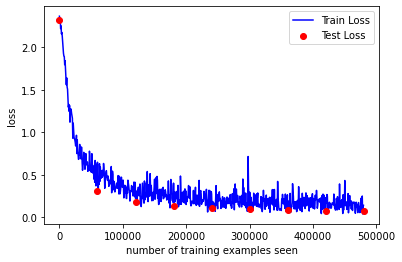

In [11]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue', zorder=1)
plt.scatter(test_counter, test_losses, color='red', zorder=2)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('loss')

In [12]:
with torch.no_grad():
    network.fc1.weight[:] = fc1_init
    #network.fc2.weight[:] = fc2_init
    #network.conv1.weight[:] = conv1_init
    #network.conv2.weight[:] = conv2_init